In [ ]:
# Importing the necessary libraries and modules.
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.io import loadmat
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import scipy.special as sp

scaler = StandardScaler()

In [ ]:
# Defining the Global Variables --> Directory, error and sparsity error.
dir = r'/content/drive/MyDrive/Datasets/BMI_datasets/classification_dataset/monkey_2_set_2' # Parent directory that contain the processed classification files.

error = 0             # Defining the error in Feedback
sparsity_rate = 0     # Sparsity in the Feedback signals
Device_HRS_mean = 88.1*1e3 # in KOhm
Device_HRS_STD = 28.6*1e3 # in KOhm
Device_LRS_mean = 9.15*1e3 # in KOhm
Device_LRS_STD = 0.92*1e3 # in KOhm
ALPHA_HRS = 1e-5
ALPHA_LRS = 1e-4

In [ ]:
# Mounting the google drive to load the dataset as needed.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the ReLU function.
def ReLU(x):
  z = np.maximum(0,x)
  return z

In [ ]:
# Generate rram matrix for substituting this matrix as random weights in Banditron-RP
def generate_rram_matrix(rram_size,hidden_size):
  np.random.seed(100)
  #hrs_mask = np.zeros((rram_size,hidden_size))
  hrs_mask = np.random.randint(0, 2, size=(rram_size,hidden_size))
  lrs_mask = np.absolute(1 - hrs_mask)
  hrs_values = np.random.normal(Device_HRS_mean, Device_HRS_STD, size=(rram_size, hidden_size))*ALPHA_HRS
  lrs_values = np.random.normal(Device_LRS_mean, Device_LRS_STD, size=(rram_size, hidden_size))*ALPHA_LRS
  rram = hrs_values*hrs_mask + lrs_values*lrs_mask # Weight matrix generation

  temp = rram.copy()
  for i in range(hidden_size):
    rram[:, i] = temp[:, (i+1)%hidden_size] - temp[:, i]

  return rram

In [ ]:
# Defining the Banditron Function (Single Layered Network)
'''
Here, **kwargs is used to denote the arbitary input functions. The error and sparse_rate
corresponds to the error and the sparsity introduced to the feedback signal (refer to the
paper to understand the physical significance). k denotes the number of classes and is
fixed at 4 for our experiments. X denotes the spike count data (observation -- input dataset)
and y denotes the true labels associated with each observation (X)
'''
def banditron(X, y, error, sparse_rate, k=4, **kwargs):
    T = X.shape[0]
    d = X.shape[1]
    np.random.seed(100)
    W = np.zeros((k, d)) # Initializing the Weight Matrix.
    error_count = np.zeros(T)
    pred = [] # The predicted labels will be stored here.

    # The exploration exploitation constant and eta are given as optional arguments.
    if "gammas" not in kwargs:
        gammas = [kwargs["gamma"] for i in range(T)]
    else:
        gammas = kwargs["gammas"]

    if "eta" in kwargs:
        eta = kwargs["eta"]

    # Evaluative framework (refer to the paper to understand the mathematics)
    for t in range(T):
        gamma = gammas[t]
        y_hat = np.argmax(np.dot(W, X[t]))
        p = [gamma/k for i in range(k)]
        p[y_hat] = p[y_hat] + 1 - gamma
        y_tilde = np.random.choice(range(k), p=p)
        pred.append(y_tilde)
        sparsify = np.random.choice([True,False],p=[sparse_rate,1-sparse_rate])
        if not sparsify:
          if y_tilde != y[t]:
            choice = np.random.choice(range(2),p=[error,1-error])
            if choice == 1:
              W[y_hat] = W[y_hat] - X[t]
            else:
              W[y_hat] = W[y_hat] - X[t]
              W[y_tilde] = W[y_tilde] + X[t] / p[y_tilde]
          else:
            choice = np.random.choice(range(2),p=[error,1-error])
            if choice == 1:
              W[y_hat] = W[y_hat] - X[t]
              W[y_tilde] = W[y_tilde] + X[t] / p[y_tilde]
            else:
              W[y_hat] = W[y_hat] - X[t]
    return pred

In [ ]:
# Defining the Banditron-RP Function (Three Layered Network)
'''
Here, **kwargs is used to denote the arbitary input functions. The error and sparse_rate
corresponds to the error and the sparsity introduced to the feedback signal (refer to the
paper to understand the physical significance). k denotes the number of classes and is
fixed at 4 for our experiments. X denotes the spike count data (observation -- input dataset)
and y denotes the true labels associated with each observation (X)
'''
def banditronRP(X, y, k, error, sparse_rate, **kwargs):
    d = X.shape[1]
    Wrand = generate_rram_matrix(d,k) # The random Weight matrix generated from a normal distribution.
    f = ReLU(np.dot(Wrand.T,X.T)) # The non-linear projection vector input to the hidden layer.
    pred = banditron(f.T, y, error, sparsity_rate, **kwargs) # f(t) = relu(Wrand.x(t)) is given as an input to the Banditron.
    return pred, Wrand

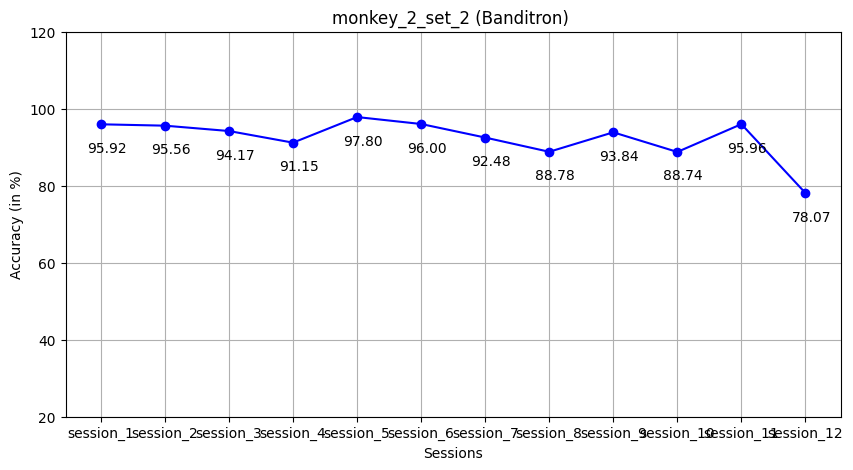

92.3703157153223


In [ ]:
# Evaluating the Banditron Algorithm
directory = dir
files = os.listdir(directory)
acc = []
error_acc = []
interval = []
'''
Defining the Exploration constant
'''
gamma = 0.0001

for file in files:
    data = loadmat(os.path.join(directory,file))
    feature_mat = data["feature_mat"]
    X = feature_mat[:,:-1]
    y = feature_mat[:,-1]//90
    pred = banditron(X, y, error, sparsity_rate, gamma=gamma)
    results = np.vstack([y*90,np.array(pred)*90]).T
    results_df = pd.DataFrame(results,columns=["True","Pred"])
    error_intervals = 1/(np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0]*100)
    error_acc.append(error_intervals)
    interval.append(2.58*np.sqrt(error_intervals*(1-error_intervals))/results_df.shape[0])
    acc.append((np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0])*100)

acc_Banditron = acc
plt.figure(figsize=(10,5))
plt.plot(range(1,len(files)+1),acc,'b-o')
plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
for x,y in zip(range(1,len(files)+1),acc):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)

plt.title(directory.split('/')[-1]+' (Banditron) ')
plt.show()
print(np.mean(acc_Banditron))

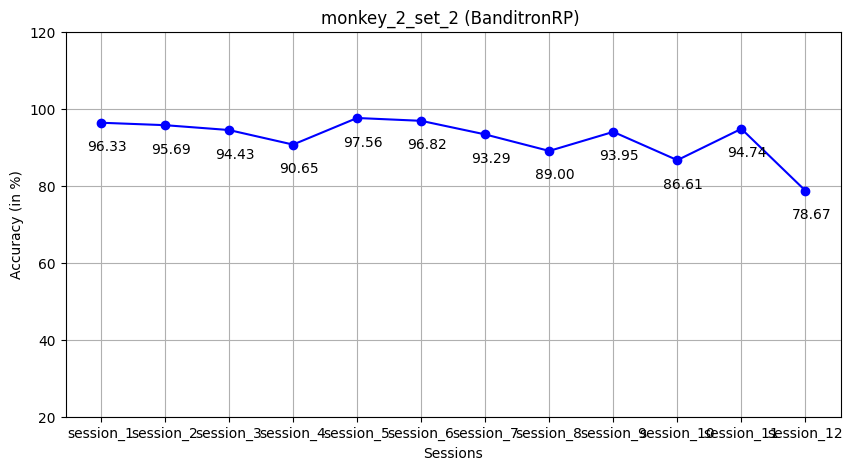

92.31060504262648


In [ ]:
# Evaluating the Banditron-RP Algorithm
directory = dir
files = os.listdir(directory)
acc = []

for file in files:
    data = loadmat(os.path.join(directory,file))
    feature_mat = data["feature_mat"]
    X = feature_mat[:,:-1]
    y = feature_mat[:,-1]//90
    pred, Wrand = banditronRP(X, y, 128, error, sparsity_rate, gamma=gamma)
    results = np.vstack([y*90,np.array(pred)*90]).T
    results_df = pd.DataFrame(results,columns=["True","Pred"])
    acc.append((np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0])*100)

acc_BanditronRP = acc
plt.figure(figsize=(10,5))
plt.plot(range(1,len(files)+1),acc,'b-o')
plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
for x,y in zip(range(1,len(files)+1),acc):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)

plt.title(directory.split('/')[-1]+' (BanditronRP) ')
plt.show()
print(np.mean(acc_BanditronRP))